In [1]:
import pystac_client
from odc.stac import load
from dask.distributed import Client as DaskClient
import matplotlib.pyplot as plt
from planetary_computer import sign_url
import leafmap.foliumap as leafmap
import json
from shapely.geometry import shape
import xarray as xr

In [2]:
dask_client = DaskClient()
dask_client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 15.62 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50011,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:50491,Total threads: 1
Dashboard: http://127.0.0.1:50411/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:50019,


In [3]:
m = leafmap.Map(draw_export=True)
m.add_basemap("ESA WorldCover 2021")
m.add_legend(builtin_legend="ESA_WorldCover")
m.add_vector("data.geojson")
m

In [4]:
with open("data.geojson", "r") as file:
    area_of_interest = json.load(file)
    area_of_interest = area_of_interest["features"][0]["geometry"]
    geom = shape(area_of_interest)
    bbox = list(geom.bounds)

In [5]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1/"
)
collection = "modis-09Q1-061"
bbox = bbox
start_date = "2022-11"
end_date = "2025-01"

In [6]:
search = catalog.search(
    collections=[collection],
    bbox=bbox,
    datetime=f"{start_date}/{end_date}",
)
items = search.item_collection()

In [7]:
len(items)

203

In [8]:
data = load(
    items,
    bands=["red", "nir08", "sur_refl_qc_250m"],
    bbox=bbox,
    chunks={"x": 2048, "y": 2048},
    groupby="solar_day",
    patch_url=sign_url,
)

In [9]:
data

<xarray.Dataset> Size: 326MB
Dimensions:           (y: 586, x: 899, time: 103)
Coordinates:
  * y                 (y) float64 5kB 1.579e+06 1.579e+06 ... 1.444e+06
  * x                 (x) float64 7kB -3.738e+05 -3.735e+05 ... -1.658e+05
    spatial_ref       int32 4B 0
  * time              (time) datetime64[ns] 824B 2022-11-01 ... 2025-01-25
Data variables:
    red               (time, y, x) int16 109MB dask.array<chunksize=(1, 586, 899), meta=np.ndarray>
    nir08             (time, y, x) int16 109MB dask.array<chunksize=(1, 586, 899), meta=np.ndarray>
    sur_refl_qc_250m  (time, y, x) uint16 109MB dask.array<chunksize=(1, 586, 899), meta=np.ndarray>

In [10]:
# Mask out low-quality pixels
mask = data.sur_refl_qc_250m.where((data.sur_refl_qc_250m & 0b11110000) == 0)

data = data.where(mask)
data = data.drop_vars("sur_refl_qc_250m")

In [11]:
ndvi = (data.nir08 - data.red) / (data.nir08 + data.red)
data["ndvi"] = ndvi.clip(-1, 1)
data = data.drop_vars(["red", "nir08"])

In [12]:
data

<xarray.Dataset> Size: 217MB
Dimensions:      (y: 586, x: 899, time: 103)
Coordinates:
  * y            (y) float64 5kB 1.579e+06 1.579e+06 ... 1.444e+06 1.444e+06
  * x            (x) float64 7kB -3.738e+05 -3.735e+05 ... -1.66e+05 -1.658e+05
    spatial_ref  int32 4B 0
  * time         (time) datetime64[ns] 824B 2022-11-01 2022-11-09 ... 2025-01-25
Data variables:
    ndvi         (time, y, x) float32 217MB dask.array<chunksize=(1, 586, 899), meta=np.ndarray>

In [13]:
data = data.compute()

In [14]:
data.to_zarr("data/ndvi.zarr", mode="w", consolidated=True)

In [15]:
# Start here if data is already downloaded
data = xr.open_zarr("data/ndvi.zarr", chunks={"time": -1, "x": 2048, "y": 2048})
ndvi = data.ndvi

In [16]:
ndvi

<xarray.DataArray 'ndvi' (time: 103, y: 586, x: 899)> Size: 217MB
dask.array<open_dataset-ndvi, shape=(103, 586, 899), dtype=float32, chunksize=(103, 586, 899), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 1.579e+06 1.579e+06 ... 1.444e+06 1.444e+06
    spatial_ref  int32 4B ...
  * x            (x) float64 7kB -3.738e+05 -3.735e+05 ... -1.66e+05 -1.658e+05
  * time         (time) datetime64[ns] 824B 2022-11-01 2022-11-09 ... 2025-01-25

In [17]:
ndvi_time_series = ndvi.mean(dim=["x", "y"])

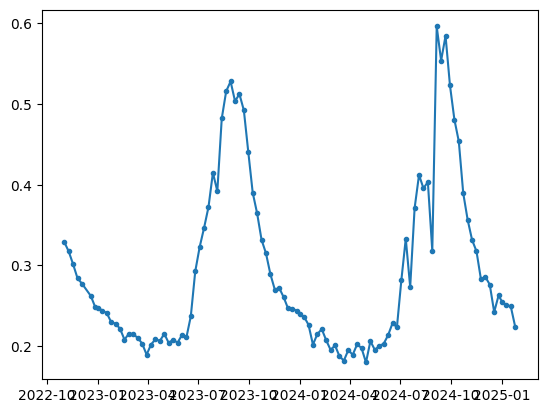

In [18]:
plt.plot(
    ndvi_time_series["time"].values,
    ndvi_time_series.values,
    marker=".",
)

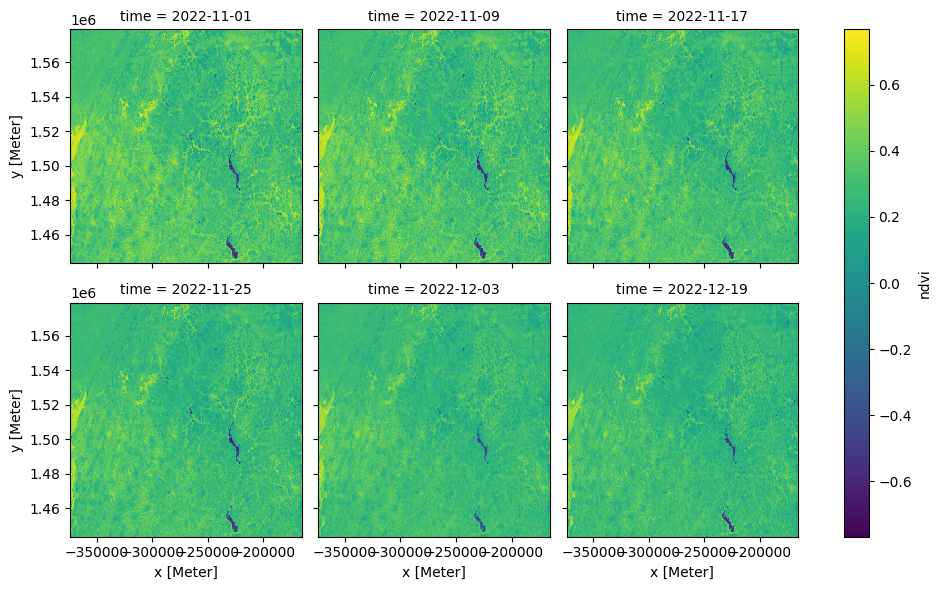

In [19]:
ndvi.isel(time=slice(0, 6)).plot(col="time", col_wrap=3, cmap="viridis")

In [20]:
filled = ndvi.interpolate_na("time", method="linear").bfill("time").ffill("time")

In [21]:
smoothed = filled.rolling(time=3, center=True).mean()

In [22]:
# start and end dates are nan after rolling average
trimmed = smoothed.isel(time=slice(1, -1))

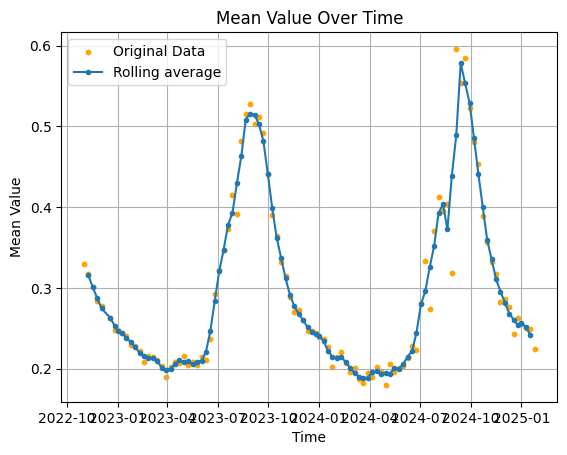

In [23]:
mean = ndvi.mean(dim=["x", "y"])
smoothed_mean = smoothed.mean(dim=["x", "y"])

plt.scatter(
    mean["time"].values,
    mean.values,
    s=10,
    color="orange",
    label="Original Data",
)
plt.plot(
    smoothed_mean["time"].values,
    smoothed_mean.values,
    marker=".",
    label="Rolling average",
)
plt.title("Mean Value Over Time")
plt.xlabel("Time")
plt.ylabel("Mean Value")
plt.grid(True)
plt.legend()

In [24]:
trimmed.to_zarr("data/ndvi_processed.zarr", mode="w", consolidated=True)